**Overview**

Vincoli:
- Modello Globale che catturi la dipendenza tra le serie storiche: Con LightGBM che è un modello globale e verrà fittato su dati che derivano da tutte le serie per il k-esimo step da prevedere
- Strategia Direct: OK
- Multiple serie storiche con un indice (panel data): OK, features calcolate nel modo corretto.
- Serie multivariate con più regressori: 
- Regressori esatti nel futuro ed altri che possono fermarsi al t corrente

In [32]:
import random
import tempfile
from pathlib import Path

import pandas as pd
from datasetsforecast.m4 import M4
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
import lightgbm as lgb
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit
from window_ops.rolling import rolling_mean


In [4]:
await M4.async_download('data', group='Hourly')
df, *_ = M4.load('data', 'Hourly')
uids = df['unique_id'].unique()
random.seed(0)
sample_uids = random.choices(uids, k=4)
df = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
df['ds'] = df['ds'].astype('int64')
df

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1
3,H196,4,10.8
4,H196,5,10.6
...,...,...,...
4027,H413,1004,99.0
4028,H413,1005,88.0
4029,H413,1006,47.0
4030,H413,1007,41.0


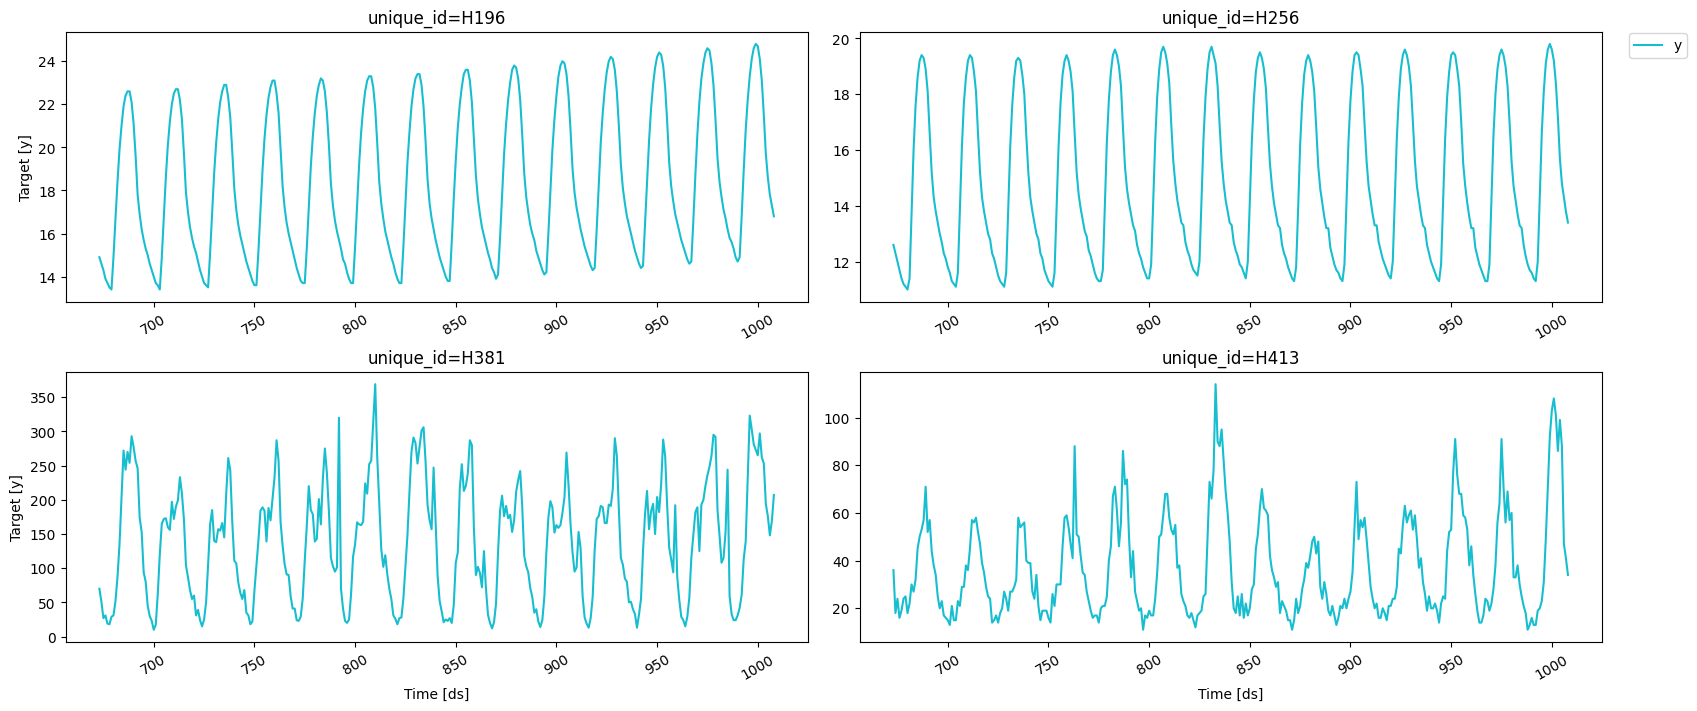

In [6]:
fig = plot_series(df, max_insample_length=24 * 14)
fig

In [16]:
df.groupby(['unique_id']).head(5)

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1
3,H196,4,10.8
4,H196,5,10.6
1008,H256,1,12.6
1009,H256,2,12.5
1010,H256,3,12.3
1011,H256,4,12.0
1012,H256,5,11.9


In [20]:
fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq=1,  # our series have integer timestamps, so we'll just add 1 in every timestep
    target_transforms=[Differences([3])],
    # date_features=[hour_index],
)
prep = fcst.preprocess(df)

In [21]:
# MLforecast capisce che le serie storiche sono indipendenti nel calcolo delle features
prep.groupby(['unique_id']).head(5)

,unique_id,ds,y
3,H196,4,-1.0
4,H196,5,-0.8
5,H196,6,-0.8
6,H196,7,-0.7
7,H196,8,0.0
1011,H256,4,-0.6
1012,H256,5,-0.6
1013,H256,6,-0.6
1014,H256,7,-0.5
1015,H256,8,-0.5


In [44]:
def hour_index(times):
    return times % 24

lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params),
    },
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 2, 3, 4, 12, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
)
fcst.fit(df, max_horizon=24)


MLForecast(models=[avg], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag12', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[<function hour_index at 0x0000011A7071DF70>], num_threads=1)

In [41]:
X, y = fcst.preprocess(df, return_X_y=True, as_numpy=True)
X

array([[ 0.2       ,  0.2       ,  0.2       , ...,  0.17464789,
         0.15      ,  0.        ],
       [ 0.1       ,  0.2       ,  0.2       , ...,  0.17361111,
         0.14583333,  1.        ],
       [ 0.3       ,  0.1       ,  0.2       , ...,  0.17534247,
         0.14166667,  2.        ],
       ...,
       [55.        , 39.        , 29.        , ...,  0.33741081,
         2.125     , 22.        ],
       [14.        , 55.        , 39.        , ...,  0.35132383,
         1.77083333, 23.        ],
       [ 3.        , 14.        , 55.        , ...,  0.35401831,
         1.20833333,  0.        ]])

In [37]:
# the following will train a single model and use the recursive strategy

def inspect_input(new_x):
    """Displays the model inputs to inspect them"""
    display(new_x)
    return new_x

preds = fcst.predict(24, before_predict_callback=inspect_input)
preds

,lag1,lag2,lag3,lag4,lag12,lag24,expanding_mean_lag1,rolling_mean_lag24_window_size48,hour_index
0,0.1,0.2,0.1,0.2,0.2,0.1,0.124593,0.172917,1
1,0.1,0.1,0.1,0.1,0.2,0.0,0.007622,-0.025000,1
2,54.0,54.0,40.0,28.0,103.0,190.0,0.733740,13.666667,1
3,4.0,3.0,14.0,55.0,-7.0,-9.0,0.357724,0.937500,1


,unique_id,ds,avg
0,H196,1009,16.401825
1,H196,1010,15.905874
2,H196,1011,15.796819
3,H196,1012,15.416025
4,H196,1013,15.088173
...,...,...,...
91,H413,1028,99.078666
92,H413,1029,46.290111
93,H413,1030,32.825969
94,H413,1031,41.269012


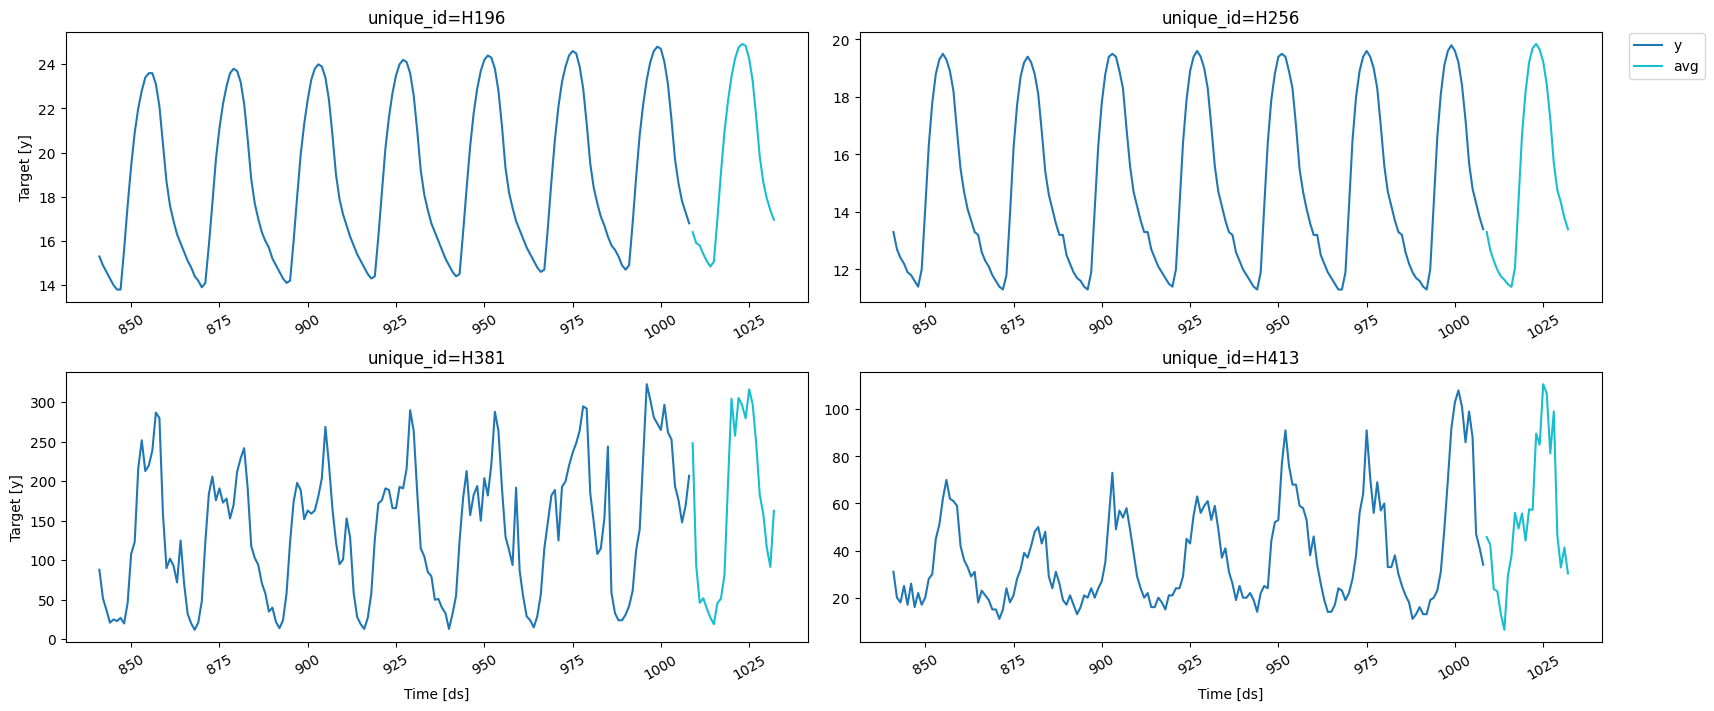

In [38]:
fig = plot_series(df, preds, max_insample_length=24 * 7)
fig